In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import csv
import nest_asyncio
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, LSTM
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix
from  sklearn.metrics import confusion_matrix, accuracy_score
import emoji
import string
from keras.utils import to_categorical
from ast import literal_eval
from sklearn.metrics import classification_report
nltk.download('stopwords')
nltk.download('punkt')
seed = 10
np.random.seed(seed)
nest_asyncio.apply()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anand\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def remove_emoji():
    """menghilangkan emoji"""
    emojis = sorted(emoji.EMOJI_DATA, key=len, reverse=True)
    pattern = u'(' + u'|'.join(re.escape(u) for u in emojis) + u')'
    return re.compile(pattern)

begone_emoji = remove_emoji()

def remove_three_same_char(value):
    """menghilangkan repitisi 3 karakter berurutan seperti gooooool"""
    pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
    return pattern.sub(r"\1\1", value)
def cleaning_text(value):
  result = value.lower().strip()
  result = remove_three_same_char(result)
  result = ' '.join(result.split())
  result = re.sub(r'(@|https?)\S+|#[A-Za-z0-9_]+', '', result).replace("&amp;", "dan")
  result = re.sub(r'RT[\s]+','',result)
  result = begone_emoji.sub(repl='', string=result)
  result = re.sub(r'[0-9]+','',result)
  result = result.replace('\n', ' ')
  result = result.translate(str.maketrans('','',string.punctuation))
  return result

def tokenizing_text(value):
  result= word_tokenize(value)
  return result

def filtering_stopwords(value):
  list_stopwords = set(stopwords.words('indonesian'))
  list_stopwords.remove("tidak")
  filtered = []
  for text in value:
    if text not in list_stopwords:
      filtered.append(text)
  return filtered

def stemming_text(value):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  return [stemmer.stem(word) for word in value]

def sentence_make(tokenized):
  return ' '.join(word for word in tokenized)


def remove_slang(value):
    kamus = eval(open("combined_slang_words.txt").read())
    pattern = re.compile(r"\b(%s)\b" % "|".join(kamus))
    converted = pattern.sub(lambda word: kamus.get(word.group()), value)
    # clear = re.sub(r'[^\w\s]', ' ', converted)
    return converted

In [28]:
list_stopwords = set(stopwords.words('indonesian'))
print(list_stopwords)

{'membuat', 'berarti', 'mampu', 'sampai', 'berikut', 'mendapat', 'bagaikan', 'kasus', 'terhadap', 'pertama-tama', 'namun', 'buat', 'inginkan', 'sampaikan', 'tertuju', 'meminta', 'ditunjuki', 'kapan', 'bahwasanya', 'soal', 'masa', 'padanya', 'sebut', 'seolah', 'sesama', 'mulanya', 'tiap', 'sekitar', 'sebisanya', 'berkali-kali', 'kalau', 'saling', 'mengingat', 'meyakinkan', 'ikut', 'seringnya', 'sedang', 'benarkah', 'sajalah', 'sejauh', 'terjadilah', 'ibaratnya', 'ingat', 'belakang', 'kamulah', 'bukanlah', 'kira', 'demikianlah', 'mampukah', 'bahkan', 'atau', 'mempersiapkan', 'sebutnya', 'kebetulan', 'setempat', 'perlu', 'malah', 'merupakan', 'masih', 'mirip', 'memerlukan', 'mendatangi', 'inginkah', 'diberikannya', 'ingin', 'sudahkah', 'paling', 'tidakkah', 'perlukah', 'melalui', 'tetap', 'usai', 'ternyata', 'tentunya', 'kembali', 'sama-sama', 'sebaik', 'lagi', 'dilakukan', 'antara', 'tuturnya', 'terbanyak', 'olehnya', 'tiga', 'lima', 'dia', 'ditegaskan', 'menanyakan', 'meyakini', 'tambah

In [3]:
text = '@siapkawalpolri Setuju nih sama usulan baru mengenai ETLE ini dari pak @ListyoSigitP agar tidak terjadi lagi hal² yang berbau pungli oleh oknum polisi yang hanya ingin memperkaya diri! https://t.co/cUEmAFuFgA'
text = text.lower()
print(text)
text = cleaning_text(text)
print(text)
text = remove_slang(text)
print(text)
text = tokenizing_text(text)
print(text)
text = filtering_stopwords(text)
print(text)
text = stemming_text(text)
print(text)

@siapkawalpolri setuju nih sama usulan baru mengenai etle ini dari pak @listyosigitp agar tidak terjadi lagi hal² yang berbau pungli oleh oknum polisi yang hanya ingin memperkaya diri! https://t.co/cuemafufga
 setuju nih sama usulan baru mengenai etle ini dari pak  agar tidak terjadi lagi hal² yang berbau pungli oleh oknum polisi yang hanya ingin memperkaya diri 
 setuju ini sama usulan baru mengenai etle ini dari pak  agar tidak terjadi lagi hal² yang berbau pungutan liar oleh oknum polisi yang hanya ingin memperkaya diri 
['setuju', 'ini', 'sama', 'usulan', 'baru', 'mengenai', 'etle', 'ini', 'dari', 'pak', 'agar', 'tidak', 'terjadi', 'lagi', 'hal²', 'yang', 'berbau', 'pungutan', 'liar', 'oleh', 'oknum', 'polisi', 'yang', 'hanya', 'ingin', 'memperkaya', 'diri']
['setuju', 'usulan', 'etle', 'hal²', 'berbau', 'pungutan', 'liar', 'oknum', 'polisi', 'memperkaya']
['tuju', 'usul', 'etle', 'hal', 'bau', 'pungut', 'liar', 'oknum', 'polisi', 'kaya']


In [ ]:
df_etle = pd.read_excel('data oktober-des 2022 etilang tanpa lang dan etle.xlsx')
df_etle.head()

In [4]:
df_etle = pd.read_excel('manual_labeling_dataset.xlsx')
df_etle.head()

,tweet,manual_label
0,"Kembangkan ETLE, 7 Polda Dapat Penghargaan di ...",2
1,Sosialisasi etle dan app smart city\n\n#polsek...,1
2,"Berita populer kumparanOTO, Selasa (13/12) det...",1
3,"Mimin kasih info ya gaes, kita mau uji coba ET...",1
4,personil lalu lintas polres badung melaksanaka...,2


In [23]:
df_etle_auto = pd.read_csv('manual_data_clean_polarity.csv', sep=';')
df_etle_manual = pd.read_csv('manual_data_clean_polarity.csv', sep=';')


In [24]:
df_etle_auto.head()

,tweet,manual_label,tweet_cleaned_id,tweet_preprocessed,polarity_score,polarity
0,"Kembangkan ETLE, 7 Polda Dapat Penghargaan di ...",2,kembangkan etle polda dapat penghargaan di ra...,"['kembang', 'etle', 'polda', 'dapat', 'harga',...",6,positif
1,Sosialisasi etle dan app smart city\n\n#polsek...,1,sosialisasi etle dan app smart city,"['sosialisasi', 'etle', 'dan', 'app', 'smart',...",0,netral
2,"Berita populer kumparanOTO, Selasa (13/12) det...",1,berita populer kumparanoto selasa detail vesp...,"['berita', 'populer', 'kumparanoto', 'selasa',...",10,positif
3,"Mimin kasih info ya gaes, kita mau uji coba ET...",1,mimin kasih info ya gaes kita mau uji coba etl...,"['mimin', 'kasih', 'informasi', 'iya', 'teman'...",3,positif
4,personil lalu lintas polres badung melaksanaka...,2,personil lalu lintas polres badung melaksanaka...,"['personil', 'lalu', 'lintas', 'polres', 'badu...",-11,negatif


In [7]:
# df_etle['tweet_cleaned_id'] = df_etle['tweet'].apply(cleaning_text)
# df_etle.head()


,origin_text_id,text_id,origin_text_en,text_en,label_vader
0,"kembangkan etle , 7 polda dapat penghargaan di...",kembang etle polda dapat harga di rakernis fun...,"develop etle , 7 regional police won awards at...",develop etl region polic award gakum function ...,1
1,sosialisasi etle dan app smart city,sosialisasi etle dan app smart city,etle socialization and smart city app,etl social smart citi app,1
2,"berita populer kumparanoto , selasa 1312 detai...",berita populer kumparanoto selasa detail vespa...,"Kupang Popular News, Tuesday 1312 details Vesp...",kupang popular news tuesday detail vespa batik...,1
3,"mimin kasih info ya gaes , kita mau uji coba e...",mimin kasih info ya gaes kita mau uji coba etl...,"Mimin, give me some info, guys, we want to try...",mimin give info guy want tri etl tangerang cit...,-1
4,personil lalu lintas polres badung melaksanaka...,personil lalu lintas polres badung laksana teg...,Badung Police traffic personnel carry out a hu...,badung polic traffic personnel carri human war...,-1


In [7]:
df_etle.to_excel("manual_labeling_dataset_after_cleaning_preview.xlsx", sheet_name="tweet okt-des 2022", index=False)

In [9]:
import time
# start = time.time()
# # df_etle['tweet_preprocessed'] = df_etle['tweet_cleaned_id'].apply(remove_slang)
# df_etle['tweet_preprocessed'] = df_etle['text_id'].apply(remove_slang)
# df_etle['tweet_preprocessed'] = df_etle['tweet_preprocessed'].apply(tokenizing_text)
# # df_etle['tweet_preprocessed'] = df_etle['tweet_preprocessed'].apply(filtering_stopwords)
# df_etle['tweet_preprocessed'] = df_etle['tweet_preprocessed'].apply(stemming_text)

# df_etle.drop_duplicates(subset = 'tweet_cleaned_id', inplace = True )
df_etle.drop_duplicates(subset = 'text_id', inplace = True )
# end = time.time()
# delta = end-start
# print(f"execution time : {delta} seconds")

In [16]:
len(max(df_etle['tweet_preprocessed'], key=len))

62

In [20]:
mapper = {'positif':2, 'netral':1, 'negatif':0}
reverse_mapper ={0:'Negatif', 1:'Netral',2:'Positif'}
df_etle['label_vader'] = df_etle['label_vader'].map(mapper)

In [22]:
df_etle.to_csv('vader_encode_data_clean.csv', index=False, sep=';', header = True, index_label=None)


In [12]:
df_etle = pd.read_csv('manual_data_clean.csv', sep=';')
df_etle.head()

,tweet,manual_label,tweet_cleaned_id,tweet_preprocessed
0,"Kembangkan ETLE, 7 Polda Dapat Penghargaan di ...",2,kembangkan etle polda dapat penghargaan di ra...,"['kembang', 'etle', 'polda', 'dapat', 'harga',..."
1,Sosialisasi etle dan app smart city\n\n#polsek...,1,sosialisasi etle dan app smart city,"['sosialisasi', 'etle', 'dan', 'app', 'smart',..."
2,"Berita populer kumparanOTO, Selasa (13/12) det...",1,berita populer kumparanoto selasa detail vesp...,"['berita', 'populer', 'kumparanoto', 'selasa',..."
3,"Mimin kasih info ya gaes, kita mau uji coba ET...",1,mimin kasih info ya gaes kita mau uji coba etl...,"['mimin', 'kasih', 'informasi', 'iya', 'teman'..."
4,personil lalu lintas polres badung melaksanaka...,2,personil lalu lintas polres badung melaksanaka...,"['personil', 'lalu', 'lintas', 'polres', 'badu..."


In [11]:
def lexicon_reader(path: str) -> dict:
    with open(path, 'r') as csv_data:
        bucket = dict()
        reader = list(csv.reader(csv_data, delimiter =","))
        for row in reader[1:]:
        # print(row[0])
            bucket[row[0]] = int(row[1])
    return bucket

def sentiment_lexicon_indonesia(value):
    score = 0
    for word in value:
        word = word.replace("'","")
        if word in lexicon_positive:
            score += lexicon_positive[word]
        if word in lexicon_negative:
            score += lexicon_negative[word]
    if score > 0:
        polarity = 'positif'
    elif score < 0:
        polarity = 'negatif'
    else:
        polarity = 'netral'
    return score, polarity

lexicon_positive = lexicon_reader('positive.csv')
lexicon_negative = lexicon_reader('negative.csv')



In [14]:
def string_to_list(value):
    return literal_eval(value)

In [15]:
dtype = df_etle.dtypes
dtype

tweet                 object
manual_label           int64
tweet_cleaned_id      object
tweet_preprocessed    object
dtype: object

In [16]:
df_etle['tweet_preprocessed'] = df_etle['tweet_preprocessed'].apply(string_to_list)
sentiment = df_etle['tweet_preprocessed'].apply(sentiment_lexicon_indonesia)
sentiment = list(zip(*sentiment))
df_etle['polarity_score'] = sentiment[0]
df_etle['polarity'] = sentiment[1]

#
df_etle['polarity'].info()
df_etle.head()

<class 'pandas.core.series.Series'>
RangeIndex: 6349 entries, 0 to 6348
Series name: polarity
Non-Null Count  Dtype 
--------------  ----- 
6349 non-null   object
dtypes: object(1)
memory usage: 49.7+ KB


,tweet,manual_label,tweet_cleaned_id,tweet_preprocessed,polarity_score,polarity
0,"Kembangkan ETLE, 7 Polda Dapat Penghargaan di ...",2,kembangkan etle polda dapat penghargaan di ra...,"[kembang, etle, polda, dapat, harga, di, raker...",6,positif
1,Sosialisasi etle dan app smart city\n\n#polsek...,1,sosialisasi etle dan app smart city,"[sosialisasi, etle, dan, app, smart, city]",0,netral
2,"Berita populer kumparanOTO, Selasa (13/12) det...",1,berita populer kumparanoto selasa detail vesp...,"[berita, populer, kumparanoto, selasa, detail,...",10,positif
3,"Mimin kasih info ya gaes, kita mau uji coba ET...",1,mimin kasih info ya gaes kita mau uji coba etl...,"[mimin, kasih, informasi, iya, teman, kita, ma...",3,positif
4,personil lalu lintas polres badung melaksanaka...,2,personil lalu lintas polres badung melaksanaka...,"[personil, lalu, lintas, polres, badung, laksa...",-11,negatif


In [18]:
df_etle.to_csv('manual_data_clean_polarity.csv', index = False, header = True, index_label = False, sep=';')

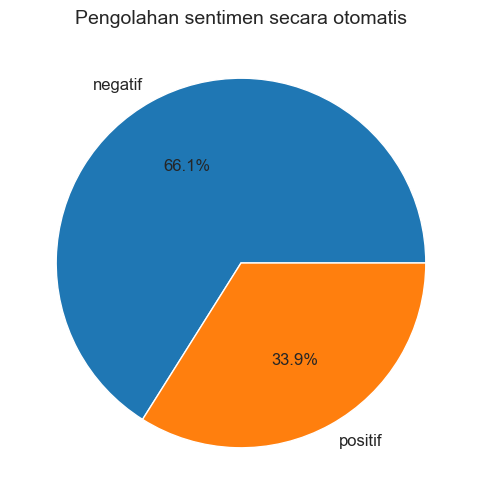

In [25]:
fig, ax = plt.subplots(figsize = (6,6))
# reverse_mapper ={0:'Negatif', 1:'Netral',2:'Positif'}
# df_etle_manual['manual_label'] = df_etle_manual['manual_label'].map(reverse_mapper)

df_etle_auto = df_etle_auto[df_etle_auto['polarity']!='netral']
sizes = [row for row in df_etle_auto['polarity'].value_counts()]
label = list(df_etle_auto['polarity'].value_counts().index)
explode = (0.1, 0,0)
ax.pie(x=sizes, labels=label, autopct = '%1.1f%%', textprops={'fontsize':12})
ax.set_title('Pengolahan sentimen secara otomatis', fontsize=14)
plt.show()

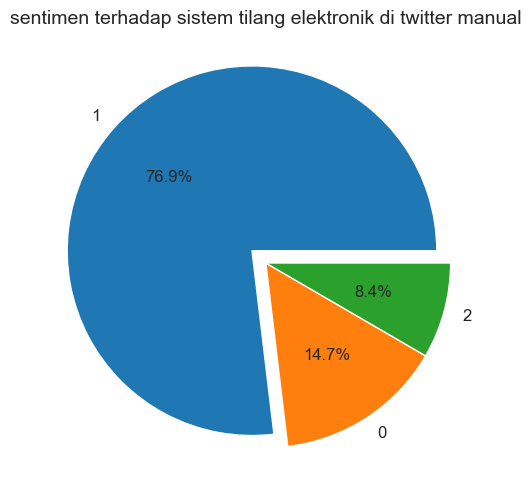

In [29]:
fig, ax = plt.subplots(figsize = (6,6))
sizes = [row for row in df_etle['manual_label'].value_counts()]
label = list(df_etle['manual_label'].value_counts().index)
explode = (0.1, 0,0)
ax.pie(x=sizes, labels=label, autopct = '%1.1f%%', explode=explode, textprops={'fontsize':12})
ax.set_title('sentimen terhadap sistem tilang elektronik di twitter manual', fontsize=14)
plt.show()

In [26]:
X = df_etle['tweet_preprocessed'].apply(sentence_make)
max_feature = 7500

tokenizer = Tokenizer(num_words=max_feature, split = ' ')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X, padding='post')

In [27]:
X.shape

(6349, 57)

In [ ]:
def LSTM_model(input_dim,output_dim,lstm_unit):
    model_lstm = Sequential()
    model_lstm.add(Embedding(input_dim=5000,output_dim=20, input_length=X.shape[1]))
    model_lstm.add(Dropout(0.5))
    model_lstm.add(LSTM(units=20, dropout=0.2, recurrent_dropout=0.2))
    model_lstm.add(Dropout(0.5))
    model_lstm.add(Dense(units=3, activation="softmax"))

    model_lstm.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    print(model_lstm.summary())
    return model_lstm

# LSTM

## LSTM 1

In [277]:
polarity_encode = {'negatif':0, 'netral':1, 'positif':2 }
# y = df_etle['polarity'].map(polarity_encode).values

y = pd.get_dummies(df_etle['polarity']).values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4, random_state = 0)
# y_test = to_categorical(y_test)
# y_train = to_categorical(y_train)

In [278]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_feature,output_dim=64, input_length=X.shape[1]))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(units=3, activation="softmax"))
model_lstm.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model_lstm.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 53, 64)            320000    
                                                                 
 dropout_70 (Dropout)        (None, 53, 64)            0         
                                                                 
 lstm_35 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_71 (Dropout)        (None, 64)                0         
                                                                 
 dense_35 (Dense)            (None, 3)                 195       
                                                                 
Total params: 353,219
Trainable params: 353,219
Non-trainable params: 0
_________________________________________________________________


In [279]:
history = model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128, verbose=1)
scores = model_lstm.evaluate(X_test, y_test, verbose=False)
print(f"Accuracy: {scores[1]*100} %")
# dir_image_save = "LSTM_file/60_40, 15, 32"


Epoch 1/15
36/36 [==============================] - 9s 122ms/step - loss: 0.9679 - accuracy: 0.5971 - val_loss: 0.8693 - val_accuracy: 0.6136
Epoch 2/15
36/36 [==============================] - 4s 102ms/step - loss: 0.7882 - accuracy: 0.6459 - val_loss: 0.7156 - val_accuracy: 0.6953
Epoch 3/15
36/36 [==============================] - 4s 100ms/step - loss: 0.6445 - accuracy: 0.7441 - val_loss: 0.6059 - val_accuracy: 0.7452
Epoch 4/15
36/36 [==============================] - 4s 103ms/step - loss: 0.5143 - accuracy: 0.7997 - val_loss: 0.5194 - val_accuracy: 0.8026
Epoch 5/15
36/36 [==============================] - 4s 99ms/step - loss: 0.4013 - accuracy: 0.8482 - val_loss: 0.4917 - val_accuracy: 0.8226
Epoch 6/15
36/36 [==============================] - 4s 102ms/step - loss: 0.3300 - accuracy: 0.8828 - val_loss: 0.4497 - val_accuracy: 0.8383
Epoch 7/15
36/36 [==============================] - 4s 101ms/step - loss: 0.2884 - accuracy: 0.8992 - val_loss: 0.4317 - val_accuracy: 0.8436
Epoch 8

In [280]:
import os
# os.makedirs(dir_image_save, exist_ok=True)
y_pred = model_lstm.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
acc = accuracy_score(y_test, y_pred)
print("Model Accuracy in Test Data : ", acc*100,"%")

96/96 [==============================] - 1s 8ms/step
Model Accuracy in Test Data :  85.17546736634962 %


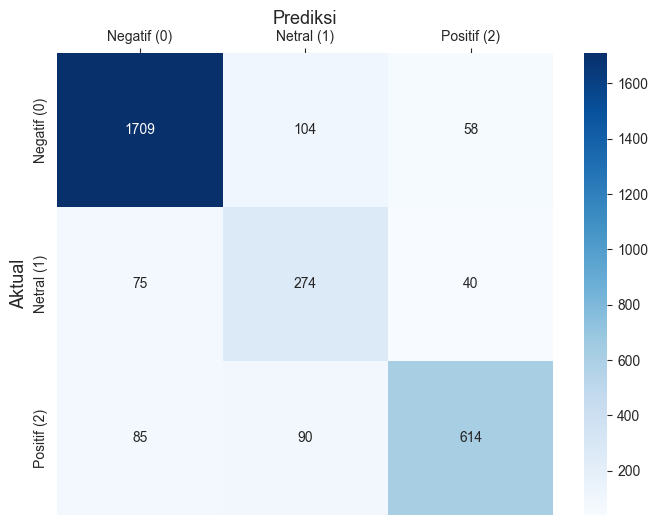

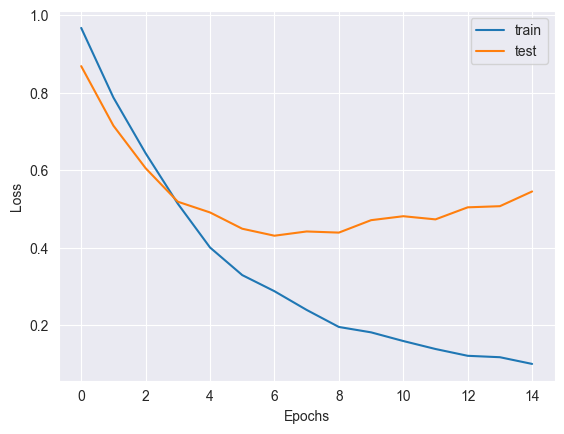

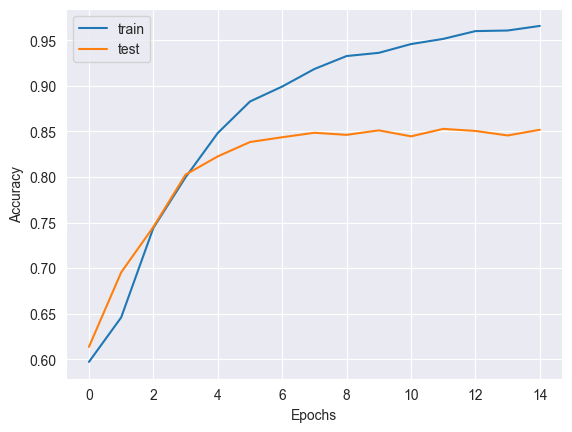

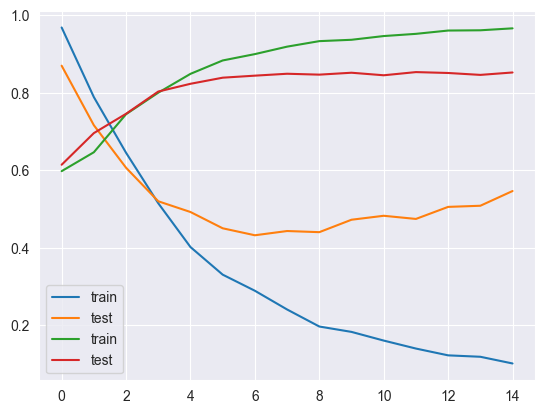

In [281]:

confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), fmt='g', annot=True, cmap='Blues')
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediksi', fontsize=13)
ax.set_xticklabels(['Negatif (0)', 'Netral (1)', 'Positif (2)'])
ax.set_ylabel('Aktual', fontsize=13)
ax.set_yticklabels(['Negatif (0)', 'Netral (1)', 'Positif (2)'])
plt.show()
# plt.imsave(f'{dir_image_save}/CF.png')
# plt.title('Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()
# plt.imsave(f'{dir_image_save}/Loss.png')
# plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='test acc')
plt.legend()
plt.show()
# plt.imsave(f'{dir_image_save}/Acc.png')

plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'test loss')
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='test acc')
plt.legend()
plt.show()


In [ ]:
def save_model(json_name, model_name, model_to_save):
    model_to_json = model_to_save.to_json()
    with open(f"{json_name}.json", 'w') as model_config:
        model_config.write(model_to_json)
    model_to_save.save_weights(f"{model_name}.h5")
    return "saved model to disk"

def plot(model_history, param):
    if param.lower() == 'loss':
        plot_param = 'loss'
        plot_loss = 'val_loss'
    else:
        plot_param = 'accuracy'
        plot_loss = 'val_accuracy'
    plt.title(param)
    plt.plot(model_history.history[plot_param], label = 'train')
    plt.plot(model_history.history[plot_loss], label = 'test')
    plt.legend()
    return plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(history.history['accuracy'], label = 'train_accuracy')
ax.plot(history.history['val_accuracy'], label = 'validation_accuracy')
ax.set_title('Model accuracy')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')
ax.legend(loc = 'upper left')
plt.show()

In [ ]:
y_pred = model_lstm.predict(X)
y_pred = np.argmax(y_pred, axis=1)
df_etle['value_polarity'] = df_etle['polarity'].apply(lambda row: polarity_encode.get(row))
df_etle['prediction'] = y_pred
df_etle.to_csv('hasil_prediksi.csv', index=False, sep=';')

In [ ]:
y_pred = model_lstm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Model Accuracy on test data: ', accuracy)
confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(confusion_matrix(y_true = y_test, y_pred = y_pred), fmt = 'b', annot=True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediction', fontsize = 13)
ax.set_xticklabels(['negatif (0)', 'netral (1)', 'positif (2)'])
ax.set_ylabel('Actual', fontsize=13)
ax.set_yticklabels(['negatif (0)', 'netral (1)', 'positif (2)'])
plt.show()